In [3]:
dataset = "mushrooms.txt"

In [4]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

In [5]:
y = 2 * y - 3

In [6]:
import numpy as np
n = 10

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Разделим наши данные на 10 клиентов

In [8]:
X_clients = np.array_split(X_train, n)
y_clients = np.array_split(y_train, n)

In [9]:
import random

In [10]:
def logistic_loss(y_pred, y_true):
    return np.log(1 + np.exp(-y_true * y_pred))

def logistic_regression(w, X, y):
    n = X.shape[0]
    y_pred = X @ w
    loss = np.sum(logistic_loss(y_pred, y)) / n
    return loss

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient(w, X, y):
    n = X.shape[0]
    y_pred = np.dot(X, w)
    sigmoid_term = 1 / (1 + np.exp(-y * y_pred))
    result = np.dot(-y + y * sigmoid_term, X) / n
    return result

def hessian(w, X, y):
    n, d = X.shape
    e = X.dot(w)
    sigmoid = 1 / (1 + np.exp(-y * e))
    diag_elements = sigmoid * (1 - sigmoid)
    return (X.T * diag_elements).dot(X) / n

In [11]:
from functools import partial

In [12]:
X_train.shape

(6499, 112)

In [13]:
X_clients[0].shape

(650, 112)

In [14]:
import numpy as np

def split_into_batches_by_count(dataset, num_batches):
    num_samples = len(np.array(dataset))
    batch_size = num_samples // num_batches
    remainder = num_samples % num_batches

    batches = []
    start = 0
    for i in range(num_batches):
        end = start + batch_size + (1 if i < remainder else 0)
        batches.append(dataset[start:end])
        start = end

    return batches


def client_update(X, y, i, client, eta_l, K):

    x = client[0].copy()
    yi = client[0].copy()
    ci = client[3]
    c = client[1]

    batches_x = split_into_batches_by_count(X_train, K)
    batches_y = split_into_batches_by_count(y_train, K)
    for k in range(K):
        grad_train = partial(gradient, X = batches_x[k], y = batches_y[k])
        gradient_i = grad_train(yi)
        yi -= eta_l * (gradient_i - ci + c)



    c_plus_i = ci - (1 / K) * eta_l * (x - yi)
    delta_yi = yi - x
    delta_ci = c_plus_i - ci


    return [delta_yi, delta_ci, yi, c_plus_i]

def server_update(x, c, M, eta_g, sum_x, sum_c, N):

    delta_x = sum_x / M
    delta_c = sum_c / M

    x += eta_g * delta_x
    c += ((M / N)) * delta_c

    return x, c


def SCAFFOLD(initial_x, initial_c, eta_g, eta_l, K, R, N, M, X_train, y_train, X_test, y_test):
    x = initial_x.copy()
    c = initial_c
    clients = np.zeros((N, 4, X_train.shape[1]))
    acc = []
    list_x = []
    list_x.append(x)

    y_pred = X_test @ x
    y_pred = (y_pred >= 0).astype(int) * 2 - 1
    acc.append(round(np.mean(y_pred == y_test), 20))

    for r in range(1, R + 1):
        S = np.random.choice(N, size=M, replace=False)
        sum_x = 0
        sum_c = 0

        for i in S:
            # 0 - now_x_i, 1 - now_c_i, 2 - last_mean, 3 - last_c
            clients[i][0] = x
            clients[i][1] = c

            clients[i] = client_update(X_train[i], y_train[i], i, clients[i], eta_l, K)
            sum_x += clients[i][0]
            sum_c += clients[i][1]

        x, c = server_update(x, c, M, eta_g, sum_x, sum_c, N)
        y_pred = X_test @ x
        y_pred = (y_pred >= 0).astype(int) * 2 - 1
        list_x.append(x)
        acc.append(round(np.mean(y_pred == y_test), 20))

    return x, c, acc, list_x


In [41]:
initial_x = np.zeros(X_train.shape[1])
initial_c = np.zeros(X_train.shape[1])

In [42]:
x, c, acc, list_x = SCAFFOLD(initial_x, initial_c, 100, 0.01, 2, 50, 10, 3, X_train, y_train, X_test, y_test)

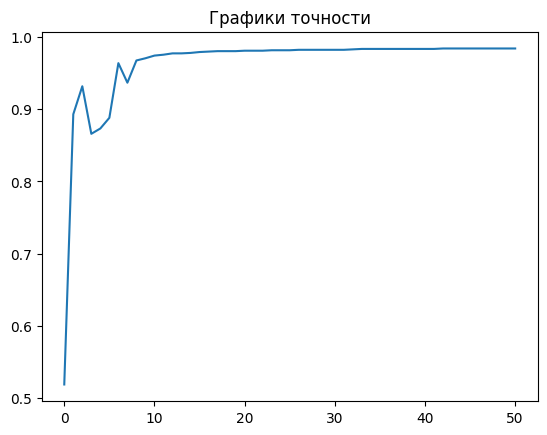

In [43]:
import matplotlib.pyplot as plt
plt.title('Графики точности')
plt.plot(acc)

In [44]:
acc[-1]

0.984

## Теперь давайте проведем наши эксперименты еще и на картинках

Начнем с датасета MNIST



 https://www.kaggle.com/code/scaomath/simple-neural-network-for-mnist-numpy-from-scratch

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read the data
train_data = pd.read_csv('/content/drive/MyDrive/mnist_train_data.csv')


# Set up the dat
y = train_data['label'].values
x = train_data.drop(columns=['label']).values/255

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [5]:
n = 50
X_clients = np.array(np.array_split(X_train, n))
y_clients = np.array(np.array_split(Y_train, n))

In [6]:
def relu(x):
    x[x<0]=0
    return x

In [7]:
def h(X,W,b):
    a1 = X
    z1 = np.matmul(X, W[0]) + b[0]
    a2 = relu(z1)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    return sigma

In [8]:
def softmax(X_in,weights):


    s = np.exp(np.matmul(X_in,weights))
    total = np.sum(s, axis=1).reshape(-1,1)
    return s / total

In [9]:
def loss(y_pred,y_true):

    global K
    K = 10
    N = len(y_true)

    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(K))
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)

    return -np.mean(loss_sample)

In [10]:
def backprop(W,b,X,y,alpha=1e-4):

    K = 10
    N = X.shape[0]
    a1 = X
    z1 = np.matmul(X, W[0]) + b[0]
    a2 = relu(z1)

    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total

    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta2 = (sigma - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)

    delta1 = np.matmul(delta2, W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)


    dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1]]
    db = [np.mean(delta1, axis=0)]
    return dW, db


In [11]:
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop
num_iter = 1000 # number of iterations of gradient descent
n_H = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10


In [12]:
def split_into_batches_by_count_mnist(dataset, num_batches):
    num_samples = len(dataset)
    batch_size = num_samples // num_batches
    remainder = num_samples % num_batches

    batches = []
    start = 0
    for i in range(num_batches):
        end = start + batch_size + (1 if i < remainder else 0)
        batches.append(dataset[start:end])
        start = end

    return np.array(batches)


def client_update_mnist(x, y, i, client1, client2, client3, eta_l, K):

    w0 = client1[0].copy()
    w1 = client2[0].copy()
    b = client3[0].copy()
    yi1 = client1[0].copy()
    yi2 = client2[0].copy()
    yi3 = client3[0].copy()
    ci1 = client1[3].copy()
    ci2 = client2[3].copy()
    ci3 = client3[3].copy()
    c1 = client1[1].copy()
    c2 = client2[1].copy()
    c3 = client3[1].copy()

    batches_x = split_into_batches_by_count_mnist(x, K)
    batches_y = split_into_batches_by_count_mnist(y, K)
    for k in range(K):
      w = [yi1, yi2]
      bb = [yi3]
      d_w, d_b=backprop(w, bb, batches_x[k],batches_y[k])

      yi1 -= eta_l * (d_w[0] - ci1 + c1)

      yi2 -= eta_l * (d_w[1] - ci2 + c2)
      yi3 -= eta_l * (d_b[0] - ci3 + c3)





    c_plus_i1 = ci1 - (1 / K) * eta_l * (w0 - yi1)
    c_plus_i2 = ci2 - (1 / K) * eta_l * (w1 - yi2)
    c_plus_i3 = ci3 - (1 / K) * eta_l * (b - yi3)
    delta_yi1 = yi1 - w0
    delta_ci1 = c_plus_i1 - ci1
    delta_yi2 = yi2 - w1
    delta_ci2 = c_plus_i2 - ci2
    delta_yi3 = yi3 - b
    delta_ci3 = c_plus_i3 - ci3



    return np.array([delta_yi1, delta_ci1, yi1, c_plus_i1]),  np.array([delta_yi2, delta_ci2, yi2, c_plus_i2]), np.array([delta_yi3, delta_ci3, yi3, c_plus_i3])

def server_update_mnist(w0, w1, b, c1, c2, c3, M, N, eta_g, sum_w0, sum_w1, sum_b, sum_c1, sum_c2, sum_c3):

    delta_w0 = sum_w0 / M
    delta_w1 = sum_w1 / M
    delta_b = sum_b / M
    delta_c1 = sum_c1 / M
    delta_c2 = sum_c2 / M
    delta_c3 = sum_c3 / M

    w0 += eta_g * delta_w0
    w1 += eta_g * delta_w1
    b += eta_g * delta_b
    c1 += (M / N) * delta_c1
    c2 += (M / N) * delta_c2
    c3 += (M / N) * delta_c3

    return w0, w1, b, c1, c2, c3

In [28]:
def SCAFFOLD_mnist2(clients_w0, clients_w1, clients_b, initial_l1, initial_l2, initial_c1, initial_c2, initial_c3, eta_g, eta_l, K, R, N, M, X_train, y_train, X_test, y_test, s):
    l1 = initial_l1.copy()
    w0 = l1[0]
    w1 = l1[1]
    l2 = initial_l2.copy()
    b = l2[0]
    print(b.shape)
    c1 = initial_c1.copy()
    c2 = initial_c2.copy()
    c3 = initial_c3.copy()
    acc = []
    lossing = []


    for r in range(1, R + 1):
        S = np.random.choice(N, size=M, replace=False)
        sum_w0 = np.zeros_like(W[0])
        sum_c1 = np.zeros_like(W[0])
        sum_w1 = np.zeros_like(W[1])
        sum_c2 = np.zeros_like(W[1])
        sum_b = np.zeros_like(b)
        sum_c3 = np.zeros_like(b)

        for i in S:

            clients_w0[i][0] = w0.copy()
            clients_w1[i][0] = w1.copy()
            clients_w0[i][1] = c1.copy()
            clients_w1[i][1] = c2.copy()
            clients_b[i][0] = b.copy()
            clients_b[i][1] = c3.copy()

            clients_w0[i], clients_w1[i], clients_b[i] = client_update_mnist(X_train[i], y_train[i], i, clients_w0[i], clients_w1[i], clients_b[i], eta_l, K)

            sum_w0 += clients_w0[i][0]

            sum_w1 += clients_w1[i][0]
            sum_b += clients_b[i][0]
            sum_c1 += clients_w0[i][1]
            sum_c2 += clients_w1[i][1]
            sum_c3 += clients_b[i][1]


        w0, w1, b, c1, c2, c3 = server_update_mnist(w0, w1, b, c1, c2, c3, M, N, eta_g, sum_w0, sum_w1, sum_b, sum_c1, sum_c2, sum_c3)
        y_pred_final = h(X_test, [w0, w1], [b])
        acc.append(np.mean(np.argmax(y_pred_final, axis=1)== y_test))
        lossing.append(loss(y_pred_final,y_test))
        # print("Final cross-entropy loss is {:.8}".format(loss(y_pred_final,y_test)))
        print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_test)))


    return l1, l2, acc, lossing

In [14]:
# initialization
np.random.seed(1127825)
W = [1e-1*np.random.randn(28 * 28, n_H), 1e-1*np.random.randn(n_H, 10)]
b = [np.random.randn(n_H)]

init_clients1 = []
init_clients2 = []
init_clients3 = []

for i in range(50):
  list1 = []
  list2 = []
  list3 = []
  for j in range(4):
    list1.append(np.zeros_like(W[0]))
    list3.append(np.zeros_like(b[0]))
    list2.append(np.zeros_like(W[1]))
  init_clients1.append(list1)
  init_clients2.append(list2)
  init_clients3.append(list3)

c1 = np.zeros_like(W[0])
c2 = np.zeros_like(W[1])
c3 = np.zeros_like(b[0])

In [15]:
x, c, acc_scaffold_mnist, lossing1 = SCAFFOLD_mnist2(init_clients1, init_clients2, init_clients3, W, b, c1, c2, c3, 50, 0.001, 10, 200, 50, 30, X_clients, y_clients, X_test, y_test, X_train.shape[1])

(256,)


<ipython-input-12-0bbbc0b0fbd0>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(batches)


Final cross-entropy loss is 8.1780954
Final training accuracy is 27.3810%
Final cross-entropy loss is 4.9187148
Final training accuracy is 25.8929%
Final cross-entropy loss is 1.9823637
Final training accuracy is 39.9167%
Final cross-entropy loss is 1.4339578
Final training accuracy is 55.1667%
Final cross-entropy loss is 1.2268633
Final training accuracy is 67.8333%
Final cross-entropy loss is 1.0495982
Final training accuracy is 74.5238%
Final cross-entropy loss is 0.92156219
Final training accuracy is 77.3214%
Final cross-entropy loss is 0.82902573
Final training accuracy is 79.6310%
Final cross-entropy loss is 0.75922789
Final training accuracy is 80.8214%
Final cross-entropy loss is 0.70539105
Final training accuracy is 81.8571%
Final cross-entropy loss is 0.66191039
Final training accuracy is 82.5476%
Final cross-entropy loss is 0.62700111
Final training accuracy is 83.1786%
Final cross-entropy loss is 0.59738301
Final training accuracy is 83.9286%
Final cross-entropy loss is 0.5

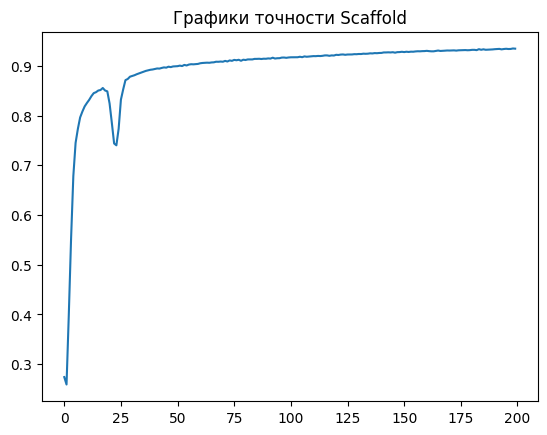

In [17]:
import matplotlib.pyplot as plt
plt.title('Графики точности Scaffold')
plt.plot(acc_scaffold_mnist)

In [20]:
diff_number_clients = []
loss_list = []
for p in range(1, 6, 1):
  np.random.seed(1127825)
  W = [1e-1*np.random.randn(28 * 28, n_H), 1e-1*np.random.randn(n_H, 10)]
  b = [np.random.randn(n_H)]

  init_clients1 = []
  init_clients2 = []
  init_clients3 = []

  for i in range(50):
    list1 = []
    list2 = []
    list3 = []
    for j in range(4):
      list1.append(np.zeros_like(W[0]))
      list3.append(np.zeros_like(b[0]))
      list2.append(np.zeros_like(W[1]))
    init_clients1.append(list1)
    init_clients2.append(list2)
    init_clients3.append(list3)

  c1 = np.zeros_like(W[0])
  c2 = np.zeros_like(W[1])
  c3 = np.zeros_like(b[0])
  x, c, acc_scaffold_mnist, lossing1 = SCAFFOLD_mnist2(init_clients1, init_clients2, init_clients3, W, b, c1, c2, c3, 50, 0.001, 10, 200, 50, p * 10, X_clients, y_clients, X_test, y_test, X_train.shape[1])
  diff_number_clients.append(acc_scaffold_mnist)
  loss_list.append(lossing1)
  print(p)

(256,)


<ipython-input-12-0bbbc0b0fbd0>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(batches)


1
(256,)
2
(256,)
3
(256,)
4
(256,)
5


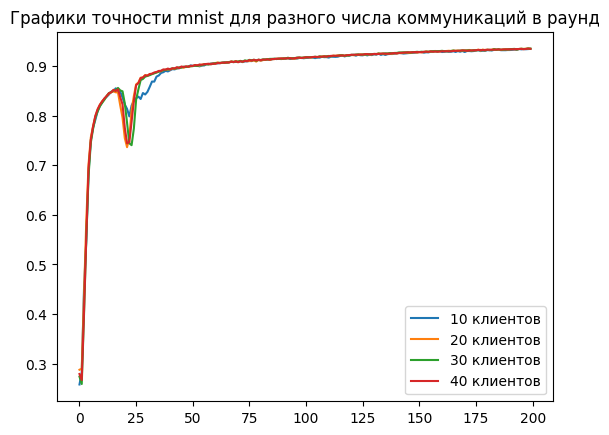

In [58]:
import matplotlib.pyplot as plt
for i in range(4):
  plt.plot(diff_number_clients[i])
plt.title('Графики точности mnist для разного числа коммуникаций в раунд')
plt.legend(('10 клиентов', '20 клиентов', '30 клиентов', '40 клиентов'))

Тепер давайте сделаем гетерогенные данные

Распределим разные цифры по разным клиентам)

In [22]:
digit_datasets = []
digit_y = []
for digit in range(10):
    digit_indices = np.where(Y_train == digit)[0]
    digit_datasets.append(X_train[digit_indices])
    digit_y.append(Y_train[digit_indices])

In [32]:
# initialization
np.random.seed(1127825)
W = [1e-1*np.random.randn(28 * 28, n_H), 1e-1*np.random.randn(n_H, 10)]
b = [np.random.randn(n_H)]

init_clients1 = []
init_clients2 = []
init_clients3 = []

for i in range(10):
  list1 = []
  list2 = []
  list3 = []
  for j in range(4):
    list1.append(np.zeros_like(W[0]))
    list3.append(np.zeros_like(b[0]))
    list2.append(np.zeros_like(W[1]))
  init_clients1.append(list1)
  init_clients2.append(list2)
  init_clients3.append(list3)

c1 = np.zeros_like(W[0])
c2 = np.zeros_like(W[1])
c3 = np.zeros_like(b[0])

In [ ]:
# x, c, acc_scaffold_he, lossing = SCAFFOLD_mnist2(init_clients1, init_clients2, init_clients3, W, b, c1, c2, c3, 30, 0.001, 10, 500, 10, 5, digit_datasets, digit_y, X_test, y_test, X_train.shape[1])

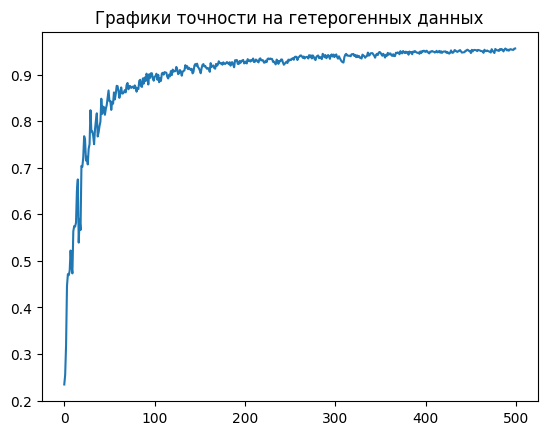

In [ ]:
import matplotlib.pyplot as plt
plt.title('Графики точности на гетерогенных данных')
plt.plot(acc_scaffold_he)

Теперь давайте сделаем еще клиентов, но пусть в каждолм лежит только одна цифра)

In [25]:
X_geter_clients = []
y_geter_clients = []
for dataset, y_dat in zip(digit_datasets, digit_y):
    subdatasets = np.array_split(dataset, 10)
    sub_y = np.array_split(y_dat, 10)
    for i in range(10):
      X_geter_clients.append(subdatasets[i])
      y_geter_clients.append(sub_y[i])


In [36]:
# initialization
np.random.seed(1127825)
W = [1e-1*np.random.randn(28 * 28, n_H), 1e-1*np.random.randn(n_H, 10)]
b = [np.random.randn(n_H)]

init_clients1 = []
init_clients2 = []
init_clients3 = []

for i in range(100):
  list1 = []
  list2 = []
  list3 = []
  for j in range(4):
    list1.append(np.zeros_like(W[0]))
    list3.append(np.zeros_like(b[0]))
    list2.append(np.zeros_like(W[1]))
  init_clients1.append(list1)
  init_clients2.append(list2)
  init_clients3.append(list3)

c1 = np.zeros_like(W[0])
c2 = np.zeros_like(W[1])
c3 = np.zeros_like(b[0])

In [37]:
x, c, acc_scaffold_100, lossing = SCAFFOLD_mnist2(init_clients1, init_clients2, init_clients3, W, b, c1, c2, c3, 30, 0.001, 10, 200, 100, 10, X_geter_clients, y_geter_clients, X_test, y_test, X_train.shape[1])

(256,)


<ipython-input-12-0bbbc0b0fbd0>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(batches)


Final training accuracy is 13.3095%
Final training accuracy is 11.8214%
Final training accuracy is 35.8333%
Final training accuracy is 43.0833%
Final training accuracy is 47.3810%
Final training accuracy is 54.9167%
Final training accuracy is 56.5595%
Final training accuracy is 60.5952%
Final training accuracy is 64.9881%
Final training accuracy is 70.1429%
Final training accuracy is 59.0000%
Final training accuracy is 61.5833%
Final training accuracy is 69.8095%
Final training accuracy is 72.0714%
Final training accuracy is 67.3571%
Final training accuracy is 67.3333%
Final training accuracy is 63.4286%
Final training accuracy is 61.9881%
Final training accuracy is 46.9643%
Final training accuracy is 68.9881%
Final training accuracy is 71.3810%
Final training accuracy is 78.3214%
Final training accuracy is 73.7857%
Final training accuracy is 75.3095%
Final training accuracy is 73.2024%
Final training accuracy is 70.3690%
Final training accuracy is 79.7381%
Final training accuracy is 7

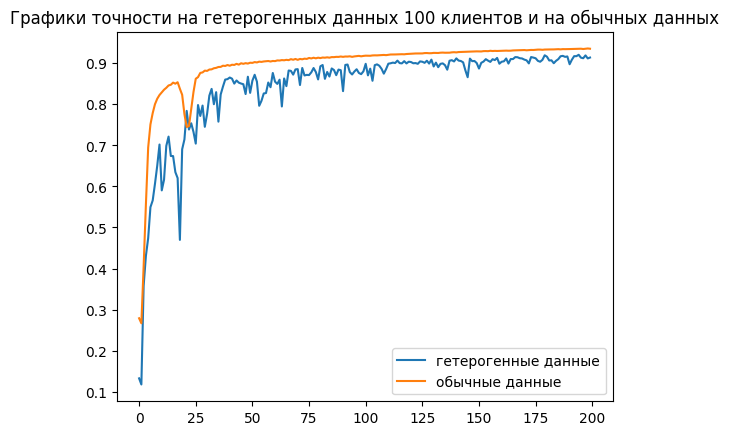

In [40]:
import matplotlib.pyplot as plt
plt.title('Графики точности на гетерогенных данных 100 клиентов и на обычных данных')
plt.plot(acc_scaffold_100)
plt.plot(diff_number_clients[3])
plt.legend(('гетерогенные данные', 'обычные данные'))

In [ ]:
acc2[-1]

0.9521428571428572

In [41]:
def client_update_mnist_avg(x, y, i, client1, client2, client3, eta_l, K):

    w0 = client1[0].copy()
    w1 = client2[0].copy()
    b = client3[0].copy()
    yi1 = client1[0].copy()
    yi2 = client2[0].copy()
    yi3 = client3[0].copy()

    batches_x = split_into_batches_by_count_mnist(x, K)
    batches_y = split_into_batches_by_count_mnist(y, K)
    for k in range(K):
      w = [yi1, yi2]
      bb = [yi3]
      d_w, d_b=backprop(w, bb, batches_x[k],batches_y[k])

      yi1 -= eta_l * (d_w[0])

      yi2 -= eta_l * (d_w[1])
      yi3 -= eta_l * (d_b[0])



    delta_yi1 = yi1 - w0
    delta_yi2 = yi2 - w1
    delta_yi3 = yi3 - b



    return np.array([delta_yi1]),  np.array([delta_yi2]), np.array([delta_yi3])

def server_update_mnist_avg(w0, w1, b, M, N, eta_g, sum_w0, sum_w1, sum_b):

    delta_w0 = sum_w0 / M
    delta_w1 = sum_w1 / M
    delta_b = sum_b / M

    w0 += eta_g * delta_w0
    w1 += eta_g * delta_w1
    b += eta_g * delta_b


    return w0, w1, b

In [42]:
def fedavg_mnist2(clients_w0, clients_w1, clients_b, initial_l1, initial_l2, eta_g, eta_l, K, R, N, M, X_train, y_train, X_test, y_test, s):
    l1 = initial_l1.copy()
    w0 = l1[0]
    w1 = l1[1]
    l2 = initial_l2.copy()
    b = l2[0]
    acc = []
    lossing = []


    for r in range(1, R + 1):
        S = np.random.choice(N, size=M, replace=False)
        sum_w0 = np.zeros_like(W[0])
        sum_w1 = np.zeros_like(W[1])
        sum_b = np.zeros_like(b)

        for i in S:

            clients_w0[i][0] = w0.copy()
            clients_w1[i][0] = w1.copy()
            clients_b[i][0] = b.copy()

            clients_w0[i], clients_w1[i], clients_b[i] = client_update_mnist_avg(X_train[i], y_train[i], i, clients_w0[i], clients_w1[i], clients_b[i], eta_l, K)

            sum_w0 += clients_w0[i][0]

            sum_w1 += clients_w1[i][0]
            sum_b += clients_b[i][0]


        w0, w1, b = server_update_mnist_avg(w0, w1, b, M, N, eta_g, sum_w0, sum_w1, sum_b)
        y_pred_final = h(X_test, [w0, w1], [b])
        acc.append(np.mean(np.argmax(y_pred_final, axis=1)== y_test))
        lossing.append(loss(y_pred_final,y_test))
        print("Final cross-entropy loss is {:.8}".format(loss(y_pred_final,y_test)))
        print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_test)))


    return l1, l2, acc, lossing

In [45]:
# initialization
np.random.seed(1127825)
W = [1e-1*np.random.randn(28 * 28, n_H), 1e-1*np.random.randn(n_H, 10)]
b = [np.random.randn(n_H)]

init_clients1 = []
init_clients2 = []
init_clients3 = []

for i in range(100):
  list1 = []
  list2 = []
  list3 = []

  list1.append(np.zeros_like(W[0]))
  list3.append(np.zeros_like(b[0]))
  list2.append(np.zeros_like(W[1]))
  init_clients1.append(list1)
  init_clients2.append(list2)
  init_clients3.append(list3)

In [46]:
x, c, acc_avg_mnist, lossing = fedavg_mnist2(init_clients1, init_clients2, init_clients3, W, b, 50, 0.001, 10, 500, 30, 10, X_clients, y_clients, X_test, y_test, X_train.shape[1])

<ipython-input-12-0bbbc0b0fbd0>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(batches)


Final cross-entropy loss is 7.8871973
Final training accuracy is 27.3095%
Final cross-entropy loss is 4.576565
Final training accuracy is 18.6667%
Final cross-entropy loss is 2.2832956
Final training accuracy is 43.0833%
Final cross-entropy loss is 1.4695181
Final training accuracy is 55.9762%
Final cross-entropy loss is 1.2564402
Final training accuracy is 66.0476%
Final cross-entropy loss is 1.0792874
Final training accuracy is 72.5357%
Final cross-entropy loss is 0.94126444
Final training accuracy is 76.8571%
Final cross-entropy loss is 0.84065797
Final training accuracy is 79.2500%
Final cross-entropy loss is 0.76713973
Final training accuracy is 80.9048%
Final cross-entropy loss is 0.70972754
Final training accuracy is 81.6667%
Final cross-entropy loss is 0.66781983
Final training accuracy is 82.8810%
Final cross-entropy loss is 0.63754339
Final training accuracy is 82.6071%
Final cross-entropy loss is 0.61616521
Final training accuracy is 83.2381%
Final cross-entropy loss is 0.60

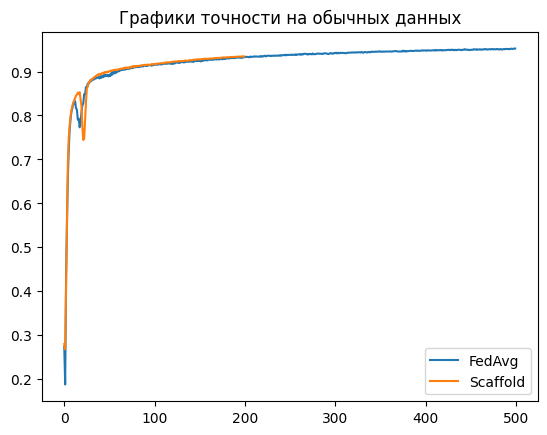

In [47]:
import matplotlib.pyplot as plt
plt.title('Графики точности на обычных данных')
plt.plot(acc_avg_mnist)
plt.plot(diff_number_clients[3])
plt.legend(('FedAvg', 'Scaffold'))

In [50]:
# initialization
np.random.seed(1127825)
W = [1e-1*np.random.randn(28 * 28, n_H), 1e-1*np.random.randn(n_H, 10)]
b = [np.random.randn(n_H)]

init_clients1 = []
init_clients2 = []
init_clients3 = []

for i in range(100):
  list1 = []
  list2 = []
  list3 = []

  list1.append(np.zeros_like(W[0]))
  list3.append(np.zeros_like(b[0]))
  list2.append(np.zeros_like(W[1]))
  init_clients1.append(list1)
  init_clients2.append(list2)
  init_clients3.append(list3)

In [ ]:
x, c, acc_fedavg_100, lossing = fedavg_mnist2(init_clients1, init_clients2, init_clients3, W, b, 1, 0.01, 10, 200, 100, 10, X_geter_clients, y_geter_clients, X_test, y_test, X_train.shape[1])

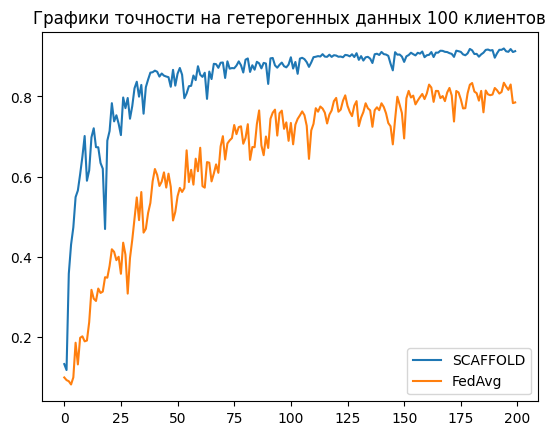

In [53]:
import matplotlib.pyplot as plt
plt.title('Графики точности на гетерогенных данных 100 клиентов')
plt.plot(acc_scaffold_100)
plt.plot(acc_fedavg_100)
plt.legend(('SCAFFOLD', 'FedAvg'))